In [1]:
from lib.abstract_torch import get_device, get_loss, get_optimizer
from lib.dataloader import get_MNIST_loaders
from lib.models import ANN, LoRA_ANN
from lib.train import train_ANN
from lib.test import test
from lib.save import save

import os
import numpy as np
import torch

In [2]:
train_vanilla = True

In [3]:
device = get_device()

In [4]:
device

device(type='cuda', index=0)

In [5]:
path = os.path.dirname(os.path.abspath("__file__"))
data_path = path + "\\data"
model_path = path + "\\ANN_LoRA\\"

Playable HPs :
- LoRA rank
- trade-off

Other HPs :
- batch_size

In [6]:
# Data parameter
batch_size=128

# Network Architecture
num_inputs = 28*28
num_hidden = 512
num_outputs = 10

# Train parameters
loss_name = "CE"
optimizer_name = "Adam"

## Reproducibility

In [7]:
random_seed = 88

## Get MNIST loaders

In [8]:
# We train on MNIST 0 to 4, then each new task is being able to classify a new digit (5 to 9)

In [9]:
train_loaders_list, val_loaders_list, test_loaders_list = get_MNIST_loaders(data_path, batch_size, random_seed, 0.7)

## Train vanilla ANN on digits 0 to 4

In [10]:
if train_vanilla :
    train_loader = train_loaders_list[0]
    test_loader = test_loaders_list[0]

In [11]:
if train_vanilla :
    lr = 1e-3
    num_epochs = 2

In [12]:
if train_vanilla :
    model = ANN(num_inputs, num_hidden, num_outputs)

In [13]:
if train_vanilla :
    train_ANN(model, loss_name, optimizer_name, lr, train_loader, num_epochs, batch_size, device)

100%|██████████| 2/2 [00:04<00:00,  2.15s/it]


In [14]:
if train_vanilla :
    test(model, test_loader, batch_size, device)

## Save vanilla ANN

In [15]:
if train_vanilla :
    vanilla_path = model_path+"ICL5_state_dict_digits_0_to_4.pth"

In [16]:
if train_vanilla :
    save(vanilla_path, model)

## CL on digits 5 to 9 with LoRA

In [17]:
import optuna
from functools import partial
import matplotlib.pyplot as plt

/home/mathis/miniconda3/envs/.jax_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
def define_model(trial, model_path, params) :
    lora_rank = trial.suggest_int("lora_rank", 8, 40)
    alpha = trial.suggest_float("alpha", 0.5, 3)
    
    num_inputs, num_hidden, num_outputs, batch_size = params
    lora_ann_model = LoRA_ANN(lora_rank,
                              alpha, 
                              model_path, 
                              num_inputs, 
                              num_hidden, 
                              num_outputs,
                              batch_size)

    return lora_ann_model

def objective(task_number, model_path, params, device, trial) :
    # Define model
    lora_ann_model = define_model(trial, model_path, params).to(device)
    
    # Set HPs
    lr = trial.suggest_float("lr", 1e-5, 5e-4)
    num_epochs = trial.suggest_int("num_epochs", 1, 4)
    
    # Train
    batch_size = params[-1]
    
    train_loader = train_loaders_list[task_number+1]
    #val_loader = val_loaders[task_number]

    train_ANN(lora_ann_model, loss_name, optimizer_name, lr, train_loader, num_epochs, batch_size, device)
    
    # Test
    test_accs = np.zeros(task_number+1)
    for j in range(task_number+1) :
        test_acc = test(lora_ann_model, test_loaders_list[j+1], batch_size, device)
        test_accs[j] = test_acc
    
    # Compute score
    mu, sigma = np.mean(test_accs), np.std(test_accs)
    score = mu - sigma
    
    return score

In [19]:
def retrain_and_save_with_best_HPs (best_trial, i, model_path) :
    lora_rank  = best_trial.params["lora_rank"]
    alpha = best_trial.params["alpha"]
    lr = best_trial.params["lr"]
    num_epochs = best_trial.params["num_epochs"]
    
    lora_ann_model = LoRA_ANN(lora_rank,
                              alpha, 
                              model_path, 
                              num_inputs, 
                              num_hidden, 
                              num_outputs,
                              batch_size).to(device)

    # Train
    train_loader = train_loaders_list[i+1]
    #val_loader = val_loaders[i]

    train_ANN(lora_ann_model, loss_name, optimizer_name, lr, train_loader, num_epochs, batch_size, device)
    
    # Test
    test_accs = np.zeros(10)
    for j in range(10) :
        test_acc = test(lora_ann_model, test_loaders_list[j+1], batch_size, device)
        test_accs[j] = test_acc
    
    # Save model
    fc1_update = lora_ann_model.model.fc1.weight + alpha*torch.mm(lora_ann_model.l1_lora_A, lora_ann_model.l1_lora_B).T
    lora_ann_model.model.fc1.weight = torch.nn.Parameter(fc1_update)
    
    fc2_update = lora_ann_model.model.fc2.weight + alpha*torch.mm(lora_ann_model.l2_lora_A, lora_ann_model.l2_lora_B).T
    lora_ann_model.model.fc2.weight = torch.nn.Parameter(fc2_update)
    
    model_path = path + f"ICL5_state_dict_digit_{i}.pth"
    save(model_path, lora_ann_model.model)
    
    return test_accs

In [20]:
# Compute scores of the model trained on the first task
model_path = path + "\\ANN_LoRA\\ICL5_state_dict_digits_0_to_4.pth"

lora_rank = 16 # The value of this parameters has no influence
alpha = 1.8 # The value of this parameter has no influence

lora_ann_model = LoRA_ANN(lora_rank,
                          alpha, 
                          model_path, 
                          num_inputs, 
                          num_hidden, 
                          num_outputs, 
                          batch_size).to(device)

# Test the model trained on digits 0 to 4
test_accs = np.zeros(10)
for j in range(5) :
    test_acc = test(lora_ann_model, test_loaders_list[j+1], batch_size, device)
    test_accs[j] = test_acc
        
# Initialize variable to store the best HPs and the scores
best_params = []
scores = [test_acc]
test_accs_matrix = [test_accs]
mean_test_accs_through_past_tasks = [test_acc]

for i in range(5,10) :
    print(f"Learning Task {i+1}")
    # Perform HPO
    storage = optuna.storages.InMemoryStorage()
    study = optuna.create_study(storage=storage,
                                study_name="The Search",
                                #sampler=
                                direction = "maximize")
    
    params = num_inputs, num_hidden, num_outputs, batch_size
    partial_objective = partial(objective, i, model_path, params, device)
    study.optimize(partial_objective,
                   n_trials=100,
                   timeout=3600)

    # Retrain and save a model with the best params
    best_trial = study.best_trial
    best_params.append(best_trial.params)
    test_accs = retrain_and_save_with_best_HPs(best_trial, i, model_path) 
    
    model_path = path + f"ICL5_state_dict_digit_{i}.pth"
    
    # Compute and store scores
    mu, sigma = np.mean(test_accs[:i+1]), np.std(test_accs[:i+1])
    score = mu - sigma
    
    scores.append(score)
    test_accs_matrix.append(test_accs)
    mean_test_accs_through_past_tasks.append(mu)

[I 2024-05-27 10:58:07,373] A new study created in memory with name: The Search


Learning Task 6


100%|██████████| 3/3 [00:01<00:00,  2.67it/s]
[I 2024-05-27 10:58:09,019] Trial 0 finished with value: 74.74733402624906 and parameters: {'lora_rank': 15, 'alpha': 2.2017751415462783, 'lr': 7.898507579145734e-05, 'num_epochs': 3}. Best is trial 0 with value: 74.74733402624906.
100%|██████████| 1/1 [00:00<00:00,  2.71it/s]
[I 2024-05-27 10:58:09,907] Trial 1 finished with value: 45.31443356934952 and parameters: {'lora_rank': 38, 'alpha': 1.0808844499881751, 'lr': 3.216646980761467e-05, 'num_epochs': 1}. Best is trial 0 with value: 74.74733402624906.
100%|██████████| 1/1 [00:00<00:00,  2.70it/s]
[I 2024-05-27 10:58:10,800] Trial 2 finished with value: 30.429221823910794 and parameters: {'lora_rank': 32, 'alpha': 2.750538848296194, 'lr': 0.0002626559679254303, 'num_epochs': 1}. Best is trial 0 with value: 74.74733402624906.
100%|██████████| 3/3 [00:01<00:00,  2.70it/s]
[I 2024-05-27 10:58:12,429] Trial 3 finished with value: 45.49710663266194 and parameters: {'lora_rank': 14, 'alpha': 2.

Learning Task 7


100%|██████████| 2/2 [00:00<00:00,  2.52it/s]
[I 2024-05-27 11:00:35,050] Trial 0 finished with value: 17.66172288075264 and parameters: {'lora_rank': 24, 'alpha': 1.071687635627964, 'lr': 0.00025633133204378846, 'num_epochs': 2}. Best is trial 0 with value: 17.66172288075264.
100%|██████████| 4/4 [00:01<00:00,  2.54it/s]
[I 2024-05-27 11:00:37,228] Trial 1 finished with value: -17.386002735105382 and parameters: {'lora_rank': 27, 'alpha': 2.7032992810422387, 'lr': 0.0002650018124105257, 'num_epochs': 4}. Best is trial 0 with value: 17.66172288075264.
100%|██████████| 3/3 [00:01<00:00,  2.51it/s]
[I 2024-05-27 11:00:39,030] Trial 2 finished with value: 46.430364782225325 and parameters: {'lora_rank': 40, 'alpha': 0.5939465526431854, 'lr': 7.223677743596274e-05, 'num_epochs': 3}. Best is trial 2 with value: 46.430364782225325.
100%|██████████| 1/1 [00:00<00:00,  2.51it/s]
[I 2024-05-27 11:00:40,028] Trial 3 finished with value: -7.985542158404172 and parameters: {'lora_rank': 39, 'alpha

Learning Task 8


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]
[I 2024-05-27 11:02:33,398] Trial 0 finished with value: 8.27719382549888 and parameters: {'lora_rank': 11, 'alpha': 0.9126330848601872, 'lr': 0.00039146639341739484, 'num_epochs': 2}. Best is trial 0 with value: 8.27719382549888.
100%|██████████| 1/1 [00:00<00:00,  2.40it/s]
[I 2024-05-27 11:02:34,509] Trial 1 finished with value: -13.228864607719046 and parameters: {'lora_rank': 26, 'alpha': 2.9909613965630384, 'lr': 0.0004212936280564522, 'num_epochs': 1}. Best is trial 0 with value: 8.27719382549888.
100%|██████████| 1/1 [00:00<00:00,  2.40it/s]
[I 2024-05-27 11:02:35,623] Trial 2 finished with value: -14.97580290834778 and parameters: {'lora_rank': 34, 'alpha': 2.3063187270324805, 'lr': 0.00048708809883972996, 'num_epochs': 1}. Best is trial 0 with value: 8.27719382549888.
100%|██████████| 3/3 [00:01<00:00,  2.40it/s]
[I 2024-05-27 11:02:37,570] Trial 3 finished with value: -9.766919170908622 and parameters: {'lora_rank': 10, 'alpha': 

Learning Task 9


100%|██████████| 3/3 [00:01<00:00,  2.61it/s]
[I 2024-05-27 11:04:47,581] Trial 0 finished with value: -14.68268372424838 and parameters: {'lora_rank': 23, 'alpha': 1.2970730977651743, 'lr': 0.0002746543374837436, 'num_epochs': 3}. Best is trial 0 with value: -14.68268372424838.
100%|██████████| 2/2 [00:00<00:00,  2.62it/s]
[I 2024-05-27 11:04:49,122] Trial 1 finished with value: -19.91643296857913 and parameters: {'lora_rank': 31, 'alpha': 1.7509059133382048, 'lr': 0.00036542727962373723, 'num_epochs': 2}. Best is trial 0 with value: -14.68268372424838.
100%|██████████| 2/2 [00:00<00:00,  2.61it/s]
[I 2024-05-27 11:04:50,670] Trial 2 finished with value: 47.269598839261775 and parameters: {'lora_rank': 19, 'alpha': 1.479663429449114, 'lr': 7.984504195211045e-05, 'num_epochs': 2}. Best is trial 2 with value: 47.269598839261775.
100%|██████████| 2/2 [00:00<00:00,  2.63it/s]
[I 2024-05-27 11:04:52,213] Trial 3 finished with value: 16.313973830632605 and parameters: {'lora_rank': 27, 'alp

Learning Task 10


100%|██████████| 2/2 [00:00<00:00,  2.52it/s]
[I 2024-05-27 11:07:00,954] Trial 0 finished with value: 7.8618421242068735 and parameters: {'lora_rank': 35, 'alpha': 1.9221732277884551, 'lr': 9.73853004208666e-05, 'num_epochs': 2}. Best is trial 0 with value: 7.8618421242068735.
100%|██████████| 2/2 [00:00<00:00,  2.53it/s]
[I 2024-05-27 11:07:02,611] Trial 1 finished with value: -13.180188886886985 and parameters: {'lora_rank': 13, 'alpha': 2.912982861339523, 'lr': 0.00026329831975104213, 'num_epochs': 2}. Best is trial 0 with value: 7.8618421242068735.
100%|██████████| 2/2 [00:00<00:00,  2.54it/s]
[I 2024-05-27 11:07:04,263] Trial 2 finished with value: -9.5261524183293 and parameters: {'lora_rank': 39, 'alpha': 1.07183807884486, 'lr': 0.00018456565427063269, 'num_epochs': 2}. Best is trial 0 with value: 7.8618421242068735.
100%|██████████| 1/1 [00:00<00:00,  2.51it/s]
[I 2024-05-27 11:07:05,526] Trial 3 finished with value: -14.28180928921526 and parameters: {'lora_rank': 33, 'alpha'

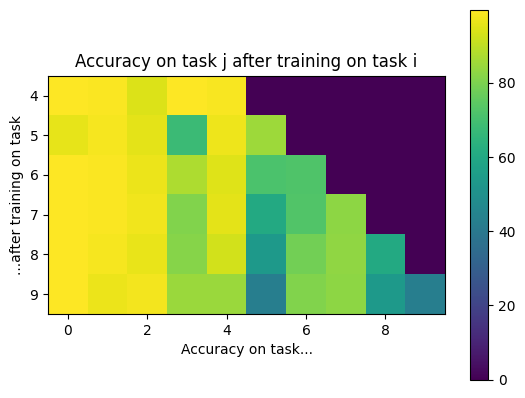

In [21]:
plt.imshow(test_accs_matrix, cmap='viridis', interpolation='nearest')
plt.yticks(np.arange(6), np.arange(4, 10))
plt.xlabel("Accuracy on task...")
plt.ylabel("...after training on task")
plt.title("Accuracy on task j after training on task i")
plt.colorbar()
plt.savefig("LoRA_greedy_HPO_matrix_ICL5.png")
plt.show()

In [22]:
np.array(test_accs_matrix).sum(1)

array([491.42517857, 540.6677381 , 621.27654762, 688.73333333,
       743.94797619, 765.52672619])